In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')
from model import CFTModel
from baselines import SurvivalModel, PosNegModel

In [24]:
# simulate condition c as a function of covariates x
# add a few more covariates that aren't informative (are noise)

n_samples = 40000

# simulate covariates (x) and conditions (c)

from sklearn.datasets import make_moons, make_circles

x0, c0 = make_moons(n_samples = n_samples, noise=.4, random_state=0)
x1, c1 = make_circles(n_samples = n_samples, noise=.3, factor=.5, random_state=0)
x2 = np.random.randn(n_samples, 1)
x = np.concatenate([x0, x1, x2], axis=1)
c = np.concatenate([c0[:, np.newaxis], c1[:, np.newaxis]], axis=1)
x = x - np.mean(x, axis=0)

In [25]:
# simulate event times as a function of c and x with uniform censoring

max_time = 3

xmu_coeffs = np.array([[0., 0., 0., 0., 1.], [0., 0., 0., 0., 1.]]).T
mu_event = np.squeeze((x @ xmu_coeffs)) + .3
sig_event = .25 * np.random.randn(n_samples, 2)

event_times = np.exp(mu_event + sig_event * np.random.randn(n_samples, 2)) + max_time * (1 - c)
censoring_times = max_time * np.random.rand(n_samples, 2)

t = np.minimum(event_times, censoring_times)
s = (t == event_times).astype(int)

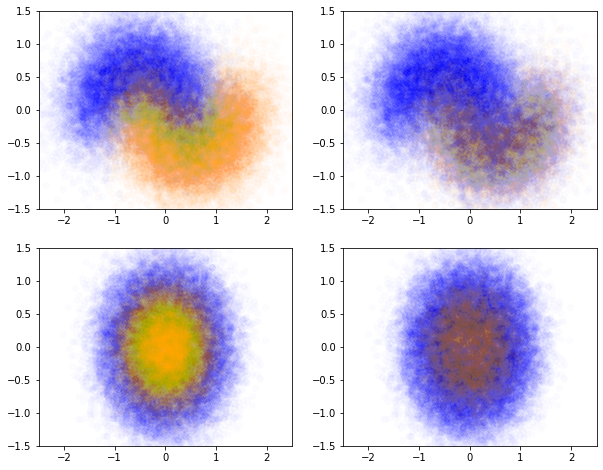

In [28]:
# visualize c (left) and s (right)

fig, ax = plt.subplots(2, 2, figsize=(10, 8))

for i in range(2):

    ax[i, 0].scatter(x[c[:, i] == 0, 2 * i], x[c[:, i] == 0, 2 * i + 1], alpha=.01, c='blue')
    ax[i, 0].scatter(x[c[:, i] == 1, 2 * i], x[c[:, i] == 1, 2 * i + 1], alpha=.01, c='orange')

    ax[i, 1].scatter(x[s[:, i] == 0, 2 * i], x[s[:, i] == 0, 2 * i + 1], alpha=.01, c='blue')
    ax[i, 1].scatter(x[s[:, i] == 1, 2 * i], x[s[:, i] == 1, 2 * i + 1], alpha=.01, c='orange')

    for j in range(2):
        ax[i, j].set_xlim([-2.5, 2.5])
        ax[i, j].set_ylim([-1.5, 1.5])

plt.show()

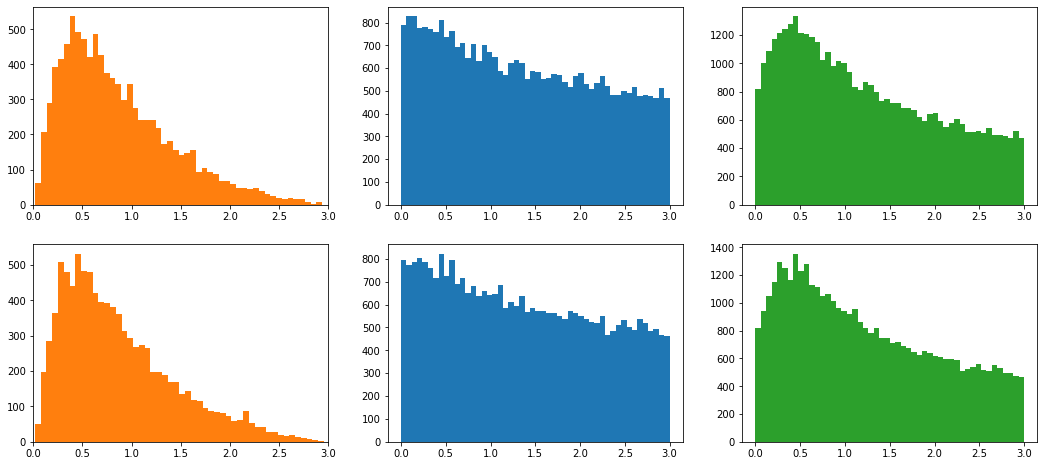

In [29]:
# visualize event times

fig, ax = plt.subplots(2, 3, figsize=(18, 8))

for i in range(2):
    
    ax[i, 0].hist(t[s[:, i] == 1, i], color='C1', bins=50)
    ax[i, 0].set_xlim([0, max_time])
    ax[i, 1].hist(t[s[:, i] == 0, i], color='C0', bins=50)
    ax[i, 2].hist(t[:, i], color='C2', bins=50)

plt.show()

In [30]:
# partition into train and validation sets

val_idx = 4 * n_samples // 5

x_train = x[:val_idx]
t_train = t[:val_idx]
s_train = s[:val_idx]
c_train = c[:val_idx]

x_val = x[val_idx:]
t_val = t[val_idx:]
s_val = s[val_idx:]
c_val = c[val_idx:]

Completed Epoch 0
Completed Epoch 10
Completed Epoch 20


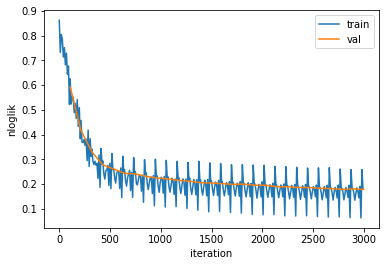

In [62]:
# Run CFT Model

tf.reset_default_graph()

cft_mdl = CFTModel(
    encoder_layer_sizes=(100,),
    decoder_layer_sizes=(100,),
    estimator='arm',
    fpr_likelihood=False,
    gs_temperature=.3,
    n_samples=100,
    dropout_pct=.5)
with tf.Session() as sess:
    train_stats, val_stats = cft_mdl.train(
        sess, x_train, t_train, s_train, x_val, t_val, s_val,
        200, max_epochs_no_improve=1, learning_rate=3e-4,
        verbose=False)
    c_pred_cft = cft_mdl.predict_c(sess, x_val)
    t_pred_cft = cft_mdl.predict_t(sess, x_val)
    
train_stats = list(zip(*train_stats))
val_stats = list(zip(*val_stats))

plt.plot(train_stats[0], train_stats[1], label='train')
plt.plot(val_stats[0], val_stats[1], label='val')
plt.xlabel('iteration')
plt.ylabel('nloglik')
plt.legend()
plt.show()

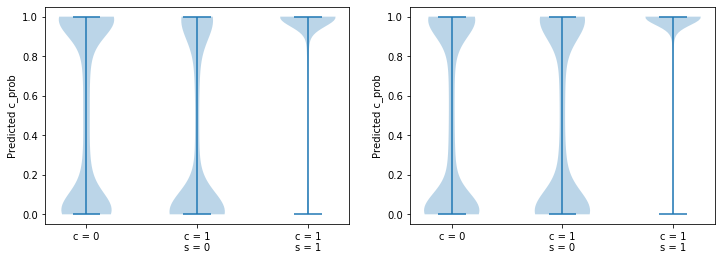

In [63]:
# Visualize CFT Predictions

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for i in range(2):
    ax[i].violinplot([
        c_pred_cft[c_val[:, i] == 0, i],
        c_pred_cft[(c_val[:, i] == 1) & (s_val[:, i] == 0), i],
        c_pred_cft[(c_val[:, i] == 1) & (s_val[:, i] == 1), i]])
    ax[i].set_xticks([1, 2, 3])
    ax[i].set_xticklabels(['c = 0', 'c = 1\ns = 0', 'c = 1\ns = 1'])
    ax[i].set_ylabel('Predicted c_prob')

plt.show()

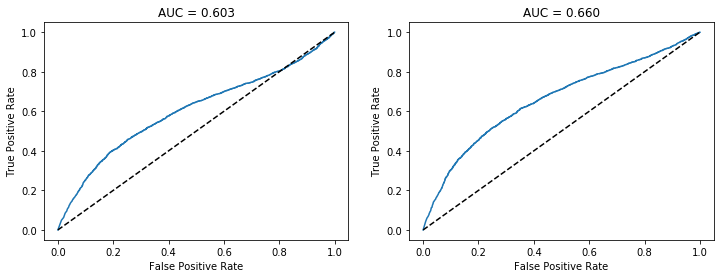

In [64]:
# CFT performance in predicting c

from sklearn.metrics import roc_curve, roc_auc_score

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for i in range(2):
    fpr, tpr, _ = roc_curve(c_val[:, i], c_pred_cft[:, i])
    ax[i].plot(fpr, tpr)
    ax[i].plot([0, 1], [0, 1], 'k--')
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')
    ax[i].set_title('AUC = %.3f' % roc_auc_score(c_val[:, i], c_pred_cft[:, i]))

plt.show()

In [53]:
# try ground truth AUC ~.9

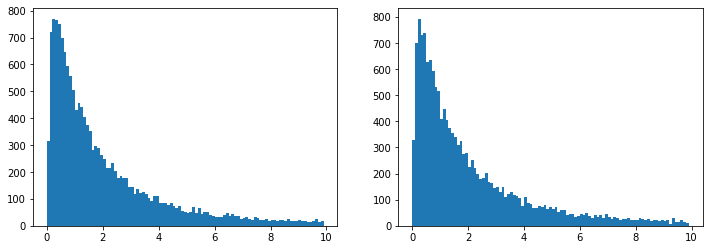

In [54]:
# CFT event time predictions

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for i in range(2):
    ax[i].hist(t_pred_cft[:, i].flatten(), bins=np.arange(100) / 10)

plt.show()

Completed Epoch 0
Completed Epoch 10
Completed Epoch 20
Completed Epoch 30
Completed Epoch 40
Completed Epoch 50
Completed Epoch 60
Completed Epoch 70
Completed Epoch 80
Completed Epoch 90
Completed Epoch 100
Completed Epoch 110
Completed Epoch 120
Completed Epoch 130
Completed Epoch 140
Completed Epoch 150
Completed Epoch 160
Completed Epoch 170
Completed Epoch 180
Completed Epoch 190


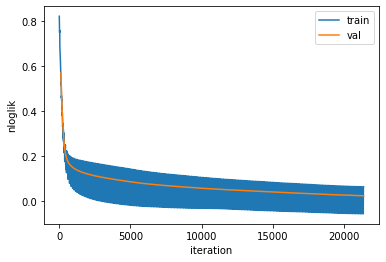

In [46]:
# Train deep survival model (not conditional)

tf.reset_default_graph()

surv_mdl = SurvivalModel(
    decoder_layer_sizes=(100,),
    dropout_pct=.5)
with tf.Session() as sess:
    train_stats, val_stats = surv_mdl.train(
        sess, x_train, t_train, s_train, x_val, t_val, s_val,
        200, max_epochs_no_improve=2, learning_rate=3e-4,
        verbose=False)
    t_pred_surv = surv_mdl.predict_t(sess, x_val)
    
train_stats = list(zip(*train_stats))
val_stats = list(zip(*val_stats))

plt.plot(train_stats[0], train_stats[1], label='train')
plt.plot(val_stats[0], val_stats[1], label='val')
plt.xlabel('iteration')
plt.ylabel('nloglik')
plt.legend()
plt.show()

Completed Epoch 0
Completed Epoch 10
Completed Epoch 20
Completed Epoch 30
Completed Epoch 40
Completed Epoch 50
Completed Epoch 60
Completed Epoch 70
Completed Epoch 80
Completed Epoch 90
Completed Epoch 100
Completed Epoch 110
Completed Epoch 120
Completed Epoch 130
Completed Epoch 140
Completed Epoch 150
Completed Epoch 160
Completed Epoch 170
Completed Epoch 180
Completed Epoch 190


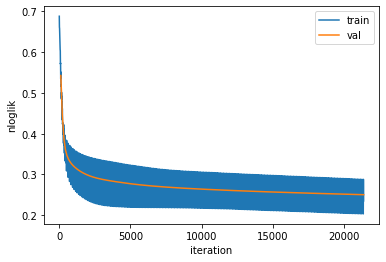

In [47]:
# Train MLP to predict s directly

tf.reset_default_graph()

posneg_mdl = PosNegModel(
    encoder_layer_sizes=(100,),
    dropout_pct=.5)
with tf.Session() as sess:
    train_stats, val_stats = posneg_mdl.train(
        sess, x_train, s_train, x_val, s_val,
        200, max_epochs_no_improve=2, learning_rate=3e-4,
        verbose=False)
    s_pred_posneg = posneg_mdl.predict_prob(sess, x_val)
    
train_stats = list(zip(*train_stats))
val_stats = list(zip(*val_stats))

plt.plot(train_stats[0], train_stats[1], label='train')
plt.plot(val_stats[0], val_stats[1], label='val')
plt.xlabel('iteration')
plt.ylabel('nloglik')
plt.legend()
plt.show()

Completed Epoch 0
Completed Epoch 10
Completed Epoch 20
Completed Epoch 30
Completed Epoch 40
Completed Epoch 50
Completed Epoch 60
Completed Epoch 70
Completed Epoch 80
Completed Epoch 90
Completed Epoch 100
Completed Epoch 110
Completed Epoch 120
Completed Epoch 130
Completed Epoch 140
Completed Epoch 150
Completed Epoch 160
Completed Epoch 170
Completed Epoch 180
Completed Epoch 190


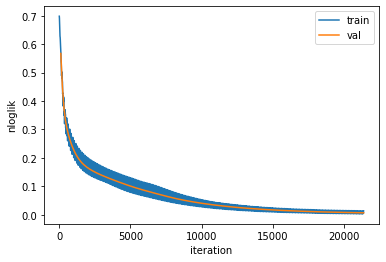

In [48]:
# Train MLP to predict c directly (to see optimal classification performance)

tf.reset_default_graph()

c_mdl = PosNegModel(
    encoder_layer_sizes=(100,),
    dropout_pct=.5)
with tf.Session() as sess:
    train_stats, val_stats = c_mdl.train(
        sess, x_train, c_train, x_val, c_val,
        200, max_epochs_no_improve=2, learning_rate=3e-4,
        verbose=False)
    c_pred_posneg = c_mdl.predict_prob(sess, x_val)
    
train_stats = list(zip(*train_stats))
val_stats = list(zip(*val_stats))

plt.plot(train_stats[0], train_stats[1], label='train')
plt.plot(val_stats[0], val_stats[1], label='val')
plt.xlabel('iteration')
plt.ylabel('nloglik')
plt.legend()
plt.show()

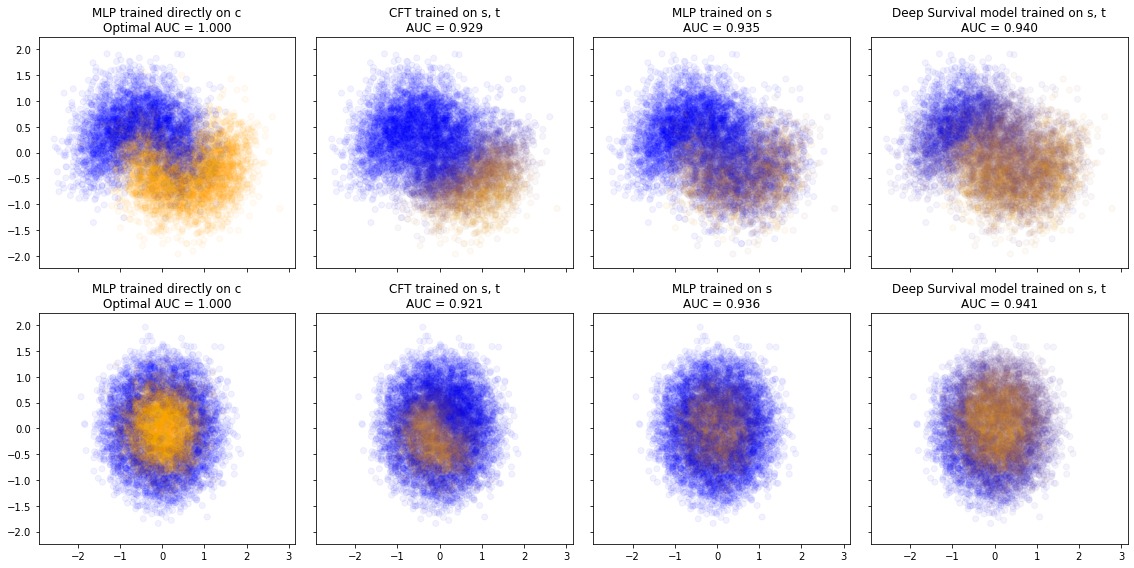

In [55]:
# Compare results between models

from matplotlib.colors import LinearSegmentedColormap
cm = LinearSegmentedColormap.from_list('BuOr', ['blue', 'orange'], N=100)

def time_to_prob(x):
    sorted_pos = {v: pos for pos, v in enumerate(sorted(x))}
    return 1 - np.array([sorted_pos[v] / len(x) for v in x])

def t_to_prob(x):
    return np.stack([time_to_prob(arr) for arr in x.T]).T

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), sharey=True, sharex=True)

for i in range(2):

    ax[i, 0].scatter(x_val[:, 2 * i], x_val[:, 2 * i + 1], c=c_pred_posneg[:, i], alpha=.05,
                     cmap=cm, vmin=0, vmax=1)
    ax[i, 0].set_title('MLP trained directly on c\nOptimal AUC = %.3f' % roc_auc_score(
        c_val[:, i], c_pred_posneg[:, i]))

    ax[i, 1].scatter(x_val[:, 2 * i], x_val[:, 2 * i + 1], c=c_pred_cft[:, i], alpha=.05,
                     cmap=cm, vmin=0, vmax=1)
    ax[i, 1].set_title('CFT trained on s, t\nAUC = %.3f' % roc_auc_score(
        c_val[:, i], c_pred_cft[:, i]))

    ax[i, 2].scatter(x_val[:, 2 * i], x_val[:, 2 * i + 1], c=s_pred_posneg[:, i], alpha=.05,
                     cmap=cm, vmin=0, vmax=1)
    ax[i, 2].set_title('MLP trained on s\nAUC = %.3f' % roc_auc_score(
        c_val[:, i], s_pred_posneg[:, i]))
    
    t_prob_surv = t_to_prob(t_pred_surv)
    ax[i, 3].scatter(x_val[:, 2 * i], x_val[:, 2 * i + 1], c=t_prob_surv[:, i], alpha=.05,
                     cmap=cm, vmin=0, vmax=1)
    ax[i, 3].set_title('Deep Survival model trained on s, t\nAUC = %.3f' % roc_auc_score(
        c_val[:, i], t_prob_surv[:, i]))

plt.tight_layout()
plt.show()

- make it a little more difficult, gaps may get a bit larger. Try to get confidence intervals on AUCs. Bootstrapping or Delong.

- need to present c-index for time to event

- start by increasing weight of term 2 in the objective